In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import joblib
from sklearn.preprocessing import LabelEncoder
# Create models folder
if not os.path.exists('models'):
    os.makedirs('models')

%matplotlib inline
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

# ---Data Loading & Initial Inspection---

In [14]:
df = pd.read_csv("data/german_credit_data.csv")
print("Data Shape:", df.shape)
display(df.head())
display(df.describe(include="all").T)
print("Risk Counts:\n", df["Risk"].value_counts())

Data Shape: (1000, 11)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,NaN,NaN,NaN,499.5,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Risk Counts:
 Risk
good    700
bad     300
Name: count, dtype: int64


In [15]:
# Handling Skewness in Credit Amount as identified in EDA
df['Credit amount_log'] = np.log(df['Credit amount'])

In [16]:
# Engineering: Monthly burden
df['Monthly_Installment'] = df['Credit amount'] / df['Duration']

In [17]:
# Imputing Missing Categorical Data
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    
display(df.head())

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Credit amount_log,Monthly_Installment
0,0,67,male,2,own,little,little,1169,6,radio/TV,good,7.063904,194.833333
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,8.691315,123.979167
2,2,49,male,1,own,little,little,2096,12,education,good,7.647786,174.666667
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,8.972337,187.666667
4,4,53,male,2,free,little,little,4870,24,car,bad,8.490849,202.916667


# Statistical Groupings (The Risk Check)

In [18]:
# Detailed check of how Risk correlates with loan size and length
risk_analysis = df.groupby("Risk").agg({
    'Age': 'mean',
    'Credit amount': 'mean',
    'Duration': 'mean',
    'Monthly_Installment': 'mean'
})
display(risk_analysis)

,Age,Credit amount,Duration,Monthly_Installment
Risk,,,,
bad,33.963333,3938.126667,24.860000,172.044031
good,36.224286,2985.457143,19.207143,165.819730


# ---Statistical Groupings (The Risk Check)----

In [19]:
# Numerical averages by Risk
display(df.groupby("Risk")[["Age", "Credit amount", "Duration"]].mean())

# Pivot Table: Purpose vs Housing
pivot = pd.pivot_table(df, values="Credit amount", index="Housing", columns="Purpose")
display(pivot)

,Age,Credit amount,Duration
Risk,,,
bad,33.963333,3938.126667,24.860000
good,36.224286,2985.457143,19.207143


Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Housing,,,,,,,,
free,4931.800000,5834.181818,NaN,4387.266667,4100.181818,2417.333333,2750.666667,7227.250
own,3800.592105,3329.949772,1546.5,2198.647059,3107.459016,2540.493392,2866.000000,8700.375
rent,5614.125000,3487.968254,1255.5,2931.000000,2727.354167,2199.763158,1522.000000,NaN


In [20]:
# Identify Categorical vs Numerical early
cat_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_features = ['Age', 'Job', 'Credit amount', 'Duration']

# Visual EDA - Distributions & Outliers

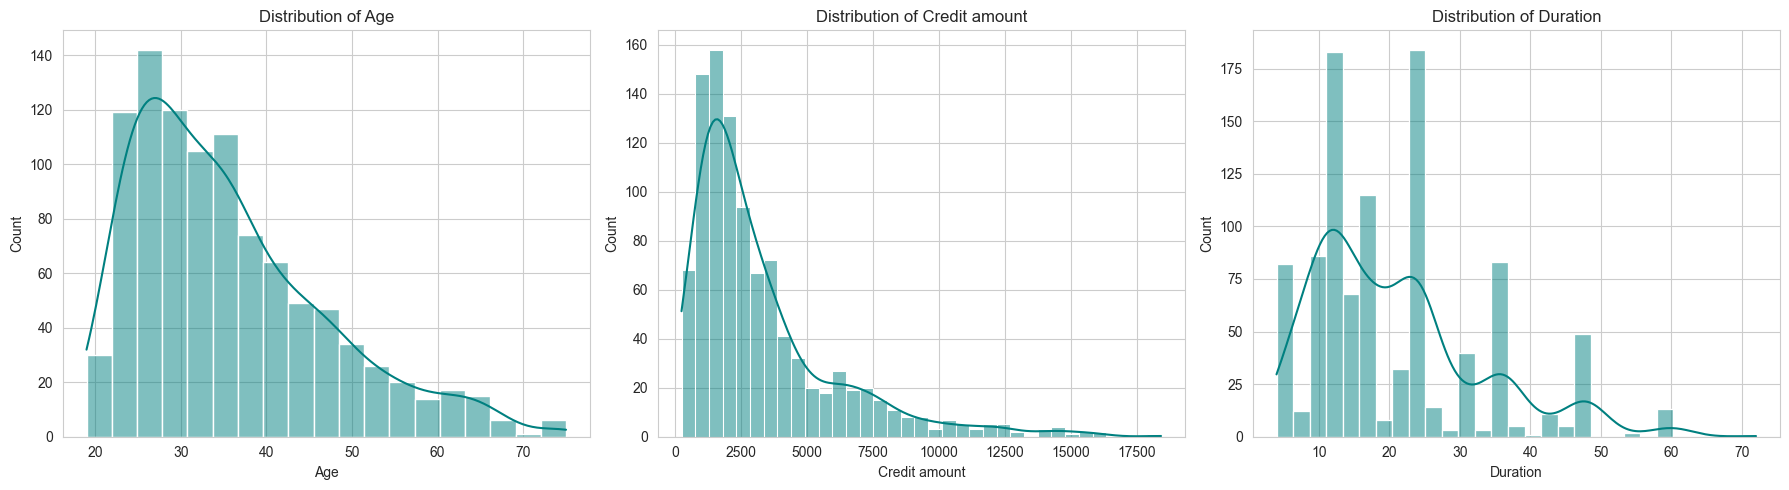

C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")


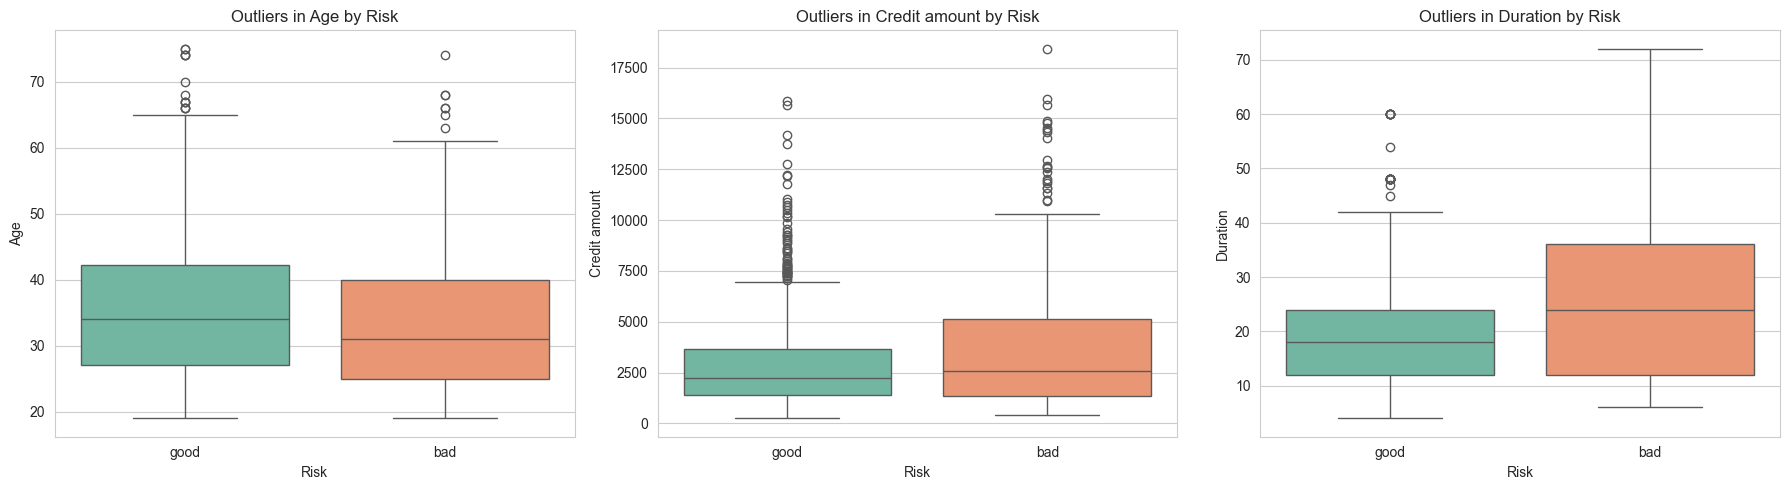

In [21]:
# 1. Histograms for Numerical Features (Checking Distribution)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
num_cols = ["Age", "Credit amount", "Duration"]

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="teal")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# 2. Boxplots for Detecting Outliers
plt.figure(figsize=(18, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
    plt.title(f"Outliers in {col} by Risk")

plt.tight_layout()
plt.show()

# Visual EDA (Distributions & Multivariate Analysis)

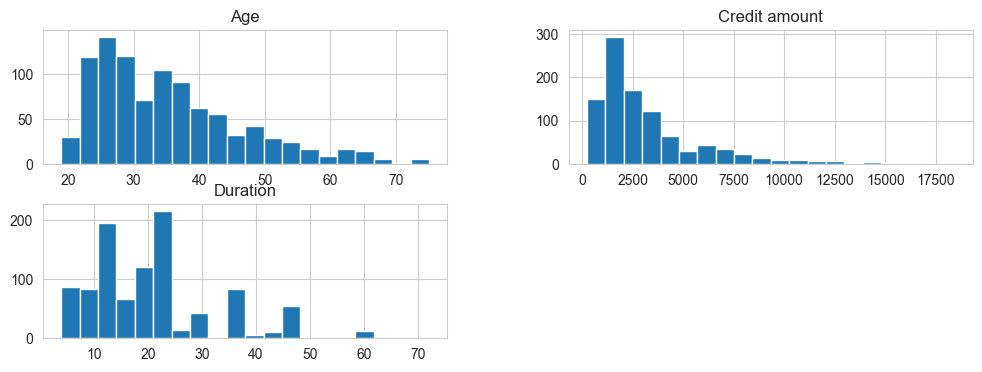

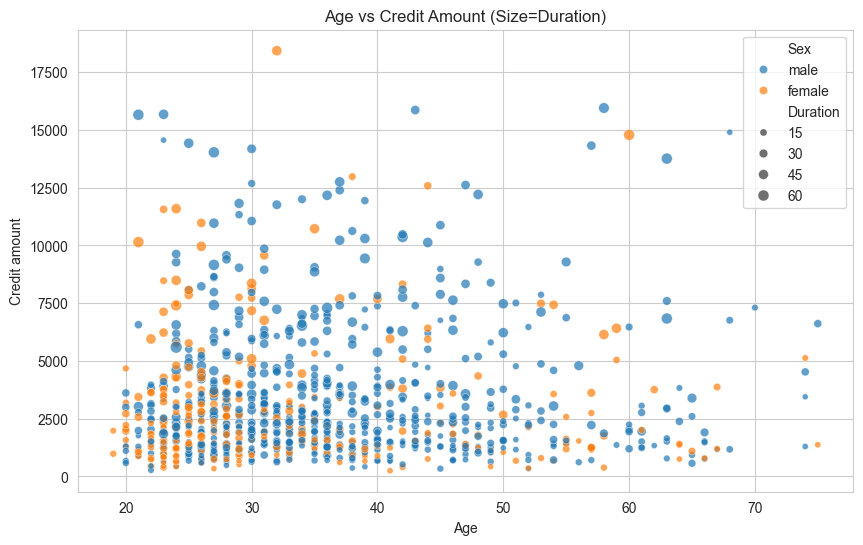

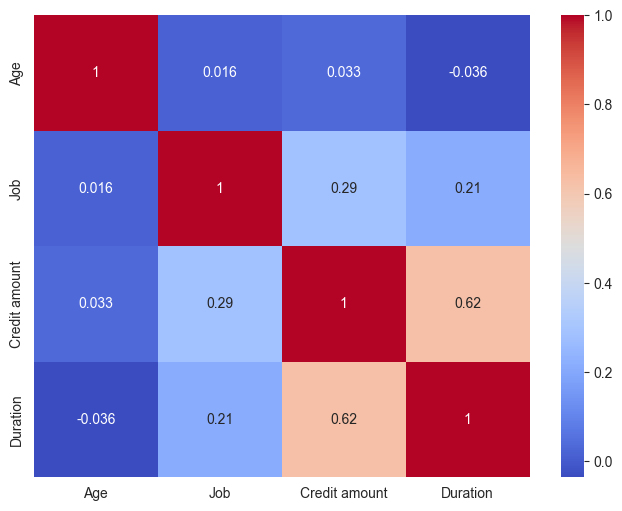

In [22]:
# Distributions
df[["Age", "Credit amount", "Duration"]].hist(bins=20, figsize=(12, 4))
plt.show()

# The "Check" Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Age", y="Credit amount", hue="Sex", size="Duration", alpha=0.7)
plt.title("Age vs Credit Amount (Size=Duration)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[["Age", "Job", "Credit amount", "Duration"]].corr(), annot=True, cmap="coolwarm")
plt.show()

# Feature Engineering

In [23]:

# Imputing & Encoding Categorical Columns
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    # Fill missing values with most frequent
    df[col] = df[col].fillna(df[col].mode()[0])
    # Initialize and Fit
    le = LabelEncoder()
    # We use .astype(str) to ensure we aren't passing numbers to the encoder
    df[col] = le.fit_transform(df[col].astype(str))
    #save to models folder immediate
    joblib.dump(le, f"models/{col}_encoder.pkl")

    print(f"Verified Encoder for {col}. classes learned: {le.classes_}")
# Handling Outliers/Skewness: Log Transformation
df['Credit amount_log'] = np.log(df['Credit amount'])

# Engineering: Monthly Installment Ratio
df['Monthly_Installment'] = df['Credit amount'] / df['Duration']
## Define Features (X) and Target (y)
# Ensure columns match exactly what app.py will send
X = df.drop(["Risk", "Unnamed: 0", "Credit amount"], axis=1, errors='ignore')
y = df["Risk"].map({"good": 1, "bad": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

Verified Encoder for Sex. classes learned: ['female' 'male']
Verified Encoder for Housing. classes learned: ['free' 'own' 'rent']
Verified Encoder for Saving accounts. classes learned: ['little' 'moderate' 'quite rich' 'rich']
Verified Encoder for Checking account. classes learned: ['little' 'moderate' 'rich']
Verified Encoder for Purpose. classes learned: ['business' 'car' 'domestic appliances' 'education' 'furniture/equipment'
 'radio/TV' 'repairs' 'vacation/others']


In [24]:
def train_model(model, params, name):
    grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    acc = accuracy_score(y_test, grid.predict(X_test))
    print(f"{name} Best Accuracy: {acc:.4f}")
    return grid.best_estimator_

# Training models
best_dt = train_model(DecisionTreeClassifier(random_state=1), {"max_depth": [3, 5, 7]}, "Decision Tree")
best_rf = train_model(RandomForestClassifier(random_state=1), {"n_estimators": [100, 200]}, "Random Forest")
best_et = train_model(ExtraTreesClassifier(random_state=1), {"n_estimators": [100, 200], "max_depth": [5, 10]}, "Extra Trees")
best_xgb = train_model(XGBClassifier(random_state=1), {"learning_rate": [0.01, 0.1]}, "XGBoost")

# Save the Extra Trees model for your App
joblib.dump(best_et, "models/best_credit_model.pkl")
print("Champion Model (Extra Trees) and Encoders successfully saved to /models/best_credit_model.pkl")

Decision Tree Best Accuracy: 0.6700
Random Forest Best Accuracy: 0.7000
Extra Trees Best Accuracy: 0.7250
XGBoost Best Accuracy: 0.7150
Champion Model (Extra Trees) and Encoders successfully saved to /models/best_credit_model.pkl
